# Black Garlic CNN Modelling via Transfer Learning

In [2]:
import tensorflow as tf
print(tf.keras.__version__)
print(tf.__version__)

physical_devices = tf.config.list_physical_devices('XPU')
physical_devices

3.4.1
2.15.0


[PhysicalDevice(name='/physical_device:XPU:0', device_type='XPU')]

## Add functions

In [2]:
#Prep the notebook
#import necessary sources 
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import pandas as pd
from keras import layers
from sklearn.metrics import accuracy_score

import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import os
import zipfile

# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=True):
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

run_counter=0

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False, name="model"): 
    # Create the confustion matrix
    global run_counter
    run_counter=run_counter+1
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with
    
    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)
    
    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
    
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
    
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    
    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.
    
    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                  horizontalalignment="center",
                  color="white" if cm[i, j] > threshold else "black",
                  size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                  horizontalalignment="center",
                  color="white" if cm[i, j] > threshold else "black",
                  size=text_size)
    
    # Save the figure to the current working directory
    if savefig:
        fig.savefig(str(run_counter)+"_"+name+"_confusion_matrix.tiff",dpi=300, bbox_inches='tight')
  
# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):

    # Import the target image and preprocess it
    img = load_and_prep_image(filename)
    
    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))
    
    # Get the predicted class
    if len(pred[0]) > 1: # check for multi-class
        pred_class = class_names[pred.argmax()] # if more than one output, take the max
    else:
        pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round
    
    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);
  
def plot_loss_curves(history,figsize=(8, 8), model_name=""):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(len(history.history['loss']))
    
    # Plot loss
    plt.figure(figsize=figsize)
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.savefig(str(run_counter)+"_"+model_name+"_loss.tiff",dpi=300,bbox_inches='tight')
    
    # Plot accuracy
    plt.figure(figsize=figsize)
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.savefig(str(run_counter)+"_"+model_name+"_accuracy.tiff",dpi=300,bbox_inches='tight')

def compare_historys(original_history, new_history, initial_epochs=5, model_name=""):

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    #plt.show()
    plt.savefig(str(run_counter)+"_"+model_name+"_tuned_history.tiff",dpi=300,bbox_inches='tight')
  
def unzip_data(filename):
    zip_ref = zipfile.ZipFile(filename, "r")
    zip_ref.extractall()
    zip_ref.close()

def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

def plot_all_curves(history=[],new_history=[],figsize=(10, 5), initial_epochs=10,model_name=""):

    vloss1 = history[0].history['val_loss']
    vloss2 = vloss1 + new_history[0].history["val_loss"]
    vloss3 =history[1].history['val_loss']
    vloss4 =vloss3 + new_history[1].history["val_loss"]
    vloss5 =history[2].history['val_loss']
    vloss6 =vloss5 + new_history[2].history["val_loss"]
    vloss7 =history[4].history['val_loss']
    vloss8 =vloss7 + new_history[3].history["val_loss"]
    vloss9 =history[4].history['val_loss']
    vloss10 =vloss9 + new_history[4].history["val_loss"]
    vloss11 =history[5].history['val_loss']
    vloss12 =vloss11 + new_history[5].history["val_loss"]


    
    vaccu1 = history[0].history['val_accuracy']
    vaccu2 = vaccu1 + new_history[0].history["val_accuracy"]
    vaccu3 = history[1].history['val_accuracy']
    vaccu4 = vaccu3 + new_history[1].history["val_accuracy"]
    vaccu5 = history[2].history['val_accuracy']
    vaccu6 = vaccu5 + new_history[2].history["val_accuracy"]
    vaccu7 = history[3].history['val_accuracy']
    vaccu8 = vaccu7 + new_history[3].history["val_accuracy"]
    vaccu9 = history[4].history['val_accuracy']
    vaccu10 = vaccu9 + new_history[4].history["val_accuracy"]
    vaccu11 = history[5].history['val_accuracy']
    vaccu12 = vaccu11 + new_history[5].history["val_accuracy"]
    
    #loss = history.history['loss']
    #val_loss = history.history['val_loss']
    
    #accuracy = history.history['accuracy']
    #val_accuracy = history.history['val_accuracy']
    
    # Plot loss
    plt.figure(figsize=figsize)
    plt.plot(vloss1, label='VGG16',color="#e6194B")
    plt.plot(vloss2, label='VGG16-tuned',color="#e6194B")
    plt.plot(vloss3, label='VGG16-augmented',color="#ffe119")
    plt.plot(vloss4, label='VGG16-augmented-tuned',color="#ffe119")
    plt.plot(vloss5, label='ResNet50v2',color="#3cb44b")
    plt.plot(vloss6, label='ResNet50v2-tuned',color="#3cb44b")
    plt.plot(vloss7, label='ResNet50v2-augmented',color="#4363d8")
    plt.plot(vloss8, label='ResNet50v2-augmented-tuned',color="#4363d8")
    plt.plot(vloss9, label='EfficientNetB0',color="#f032e6")
    plt.plot(vloss10, label='EfficientNetB0-tuned',color="#f032e6")
    plt.plot(vloss11, label='EfficientNetB0-augmented',color="#800000")
    plt.plot(vloss12, label='EfficientNetB0-augmented-tuned',color="#800000")
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.title('Validation Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.savefig(str(run_counter)+"_"+model_name+"val_loss.tiff",dpi=300,bbox_inches='tight')
    
    # Plot accuracy
    plt.figure(figsize=figsize)
    plt.plot(vaccu1, label='VGG16',color="#e6194B")
    plt.plot(vaccu2, label='VGG16-tuned',color="#e6194B")
    plt.plot(vaccu3, label='VGG16-augmented',color="#ffe119")
    plt.plot(vaccu4, label='VGG16-augmented-tuned',color="#ffe119")
    plt.plot(vaccu5, label='ResNet50v2',color="#3cb44b")
    plt.plot(vaccu6, label='ResNet50v2-tuned',color="#3cb44b")
    plt.plot(vaccu7, label='ResNet50v2-augmented',color="#4363d8")
    plt.plot(vaccu8, label='ResNet50v2-augmented-tuned',color="#4363d8")
    plt.plot(vaccu9, label='EfficientNetB0',color="#f032e6")
    plt.plot(vaccu10, label='EfficientNetB0-tuned',color="#f032e6")
    plt.plot(vaccu11, label='EfficientNetB0-augmented',color="#800000")
    plt.plot(vaccu12, label='EfficientNetB0-augmented-tuned',color="#800000")
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.title('Validation Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.savefig(str(run_counter)+"_"+model_name+"val_accuracy.tiff",dpi=300,bbox_inches='tight')
    

## Data Preparation

In [3]:

#inspect the dataset directory
walk_through_dir("black_garlic_main")

# Create training, validation and test directories
train_dir = "black_garlic_main/train/"
test_dir = "black_garlic_main/test/"
val_dir = "black_garlic_main/val/"

# Create data inputs
IMG_SIZE = (224, 224) # define image size
train_data = keras.utils.image_dataset_from_directory(directory=train_dir,
                                                      image_size=IMG_SIZE,
                                                      label_mode="categorical",
                                                      batch_size=32)
test_data = keras.utils.image_dataset_from_directory(directory=test_dir,
                                                     image_size=IMG_SIZE,
                                                     label_mode="categorical",
                                                     batch_size=32,
                                                     shuffle=False)
val_data = keras.utils.image_dataset_from_directory(directory=val_dir,
                                                    image_size=IMG_SIZE,
                                                    batch_size=32,
                                                    label_mode="categorical",
                                                    shuffle=True)


There are 3 directories and 0 images in 'black_garlic_main'.
There are 3 directories and 0 images in 'black_garlic_main/train'.
There are 0 directories and 370 images in 'black_garlic_main/train/underaged'.
There are 0 directories and 370 images in 'black_garlic_main/train/overaged'.
There are 0 directories and 370 images in 'black_garlic_main/train/excellent'.
There are 3 directories and 0 images in 'black_garlic_main/test'.
There are 0 directories and 20 images in 'black_garlic_main/test/underaged'.
There are 0 directories and 20 images in 'black_garlic_main/test/overaged'.
There are 0 directories and 20 images in 'black_garlic_main/test/excellent'.
There are 3 directories and 0 images in 'black_garlic_main/val'.
There are 0 directories and 65 images in 'black_garlic_main/val/underaged'.
There are 0 directories and 65 images in 'black_garlic_main/val/overaged'.
There are 0 directories and 65 images in 'black_garlic_main/val/excellent'.
Found 1110 files belonging to 3 classes.


2024-07-18 13:11:27.963793: I tensorflow/core/common_runtime/next_pluggable_device/next_pluggable_device_factory.cc:118] Created 1 TensorFlow NextPluggableDevices. Physical device type: XPU


Found 60 files belonging to 3 classes.
Found 195 files belonging to 3 classes.


In [4]:
#Script to generate important details and figures
res = []
def generate_details(model,test_data,history,tuned=False):
    print("Evaluating...")
    loaded_loss, loaded_accuracy = model.evaluate(test_data)
    loaded_loss, loaded_accuracy
    print("done.")
    #make predictions usind the model
    print("Predicting...")
    pred_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it will take
    print("done.")

    #save the evaluation results for tabulation
    res.append([model.name,round(loaded_loss*100,4),round(loaded_accuracy*100,4)])
    
    # Get the class predicitons of each label
    pred_classes = pred_probs.argmax(axis=1)
    
    # How do they look?
    pred_classes[:10]
    
    # make labels using unbatch
    y_labels = []
    for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
      y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
    y_labels[:10] # check what they look like (unshuffled)
    
    # Get accuracy score by comparing predicted classes to ground truth labels
    sklearn_accuracy = accuracy_score(y_labels, pred_classes)
    sklearn_accuracy
    
    # Does the evaluate method compare to the Scikit-Learn measured accuracy?
    import numpy as np
    print(f"Close? {np.isclose(loaded_accuracy, sklearn_accuracy)} | Difference: {loaded_accuracy - sklearn_accuracy}")
    
    # Get the class names
    class_names = test_data.class_names
    class_names[:10]
    
    #Genrate the confusion matrix
    make_confusion_matrix(y_true=y_labels,
                          y_pred=pred_classes,
                          classes=class_names,
                          figsize=(5, 5),
                          text_size=10,
                          norm=True,#with percentage
                          savefig=True,
                          name=model.name)
    if tuned:
        #plot hystorys
        compare_historys(original_history=history[0],
                         new_history=history[1],
                         initial_epochs=history[2],
                         model_name=model.name)
    else:
        #Plot the curves
        plot_loss_curves(history[0],figsize=(6, 3), model_name=model.name)


# Setup checkpoint path
def setup_checkpoint(model_name):
    weights_checkpoint_path = "checkpoints/"+model_name+".weights.h5"
    model_checkpoint_path = "checkpoints/"+model_name+"model.keras" 
    
    # Create a ModelCheckpoint callback that saves the model's weights only
    weights_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=weights_checkpoint_path,
                                                             save_weights_only=True, # set to False to save the entire model
                                                             save_best_only=True, # save only the best model weights instead of a model every epoch
                                                             save_freq="epoch", # save every epoch
                                                             verbose=1)
    
    # Create a ModelCheckpoint callback that saves the whole model
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=model_checkpoint_path,
                                                             save_best_only=True, # save only the best model weights instead of a model every epoch
                                                             save_freq="epoch", # save every epoch
                                                             verbose=1)
    
    return (weights_checkpoint_callback, weights_checkpoint_path)

#results printer
def show_results(results):
    all_results = pd.DataFrame(results, columns=["Model", "Loss", "Accuracy"])
    all_results.to_csv('RESULTS.csv')
    return all_results

In [5]:
class_names = test_data.class_names
class_names

['excellent', 'overaged', 'underaged']

# Model 1 EfficientNetB0

In [6]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = tf.keras.layers.Dense(3, activation="softmax", name="output_layer")(x)
model_1 = tf.keras.Model(inputs, outputs)
model_1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)
              
model_1.name="Model_1_EfficientNetB0"

(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_1.name)

history1 = model_1.fit(train_data,
                       epochs=10,
                       validation_data=val_data,
                       callbacks=[checkpoint_callback]
                      )

Epoch 1/10


2024-07-18 13:11:32.932962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type XPU is enabled.


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.5579 - loss: 0.9241
Epoch 1: val_loss improved from inf to 0.60091, saving model to checkpoints/Model_1_EfficientNetB0.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 295ms/step - accuracy: 0.5605 - loss: 0.9215 - val_accuracy: 0.8256 - val_loss: 0.6009
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.8180 - loss: 0.5933
Epoch 2: val_loss improved from 0.60091 to 0.43619, saving model to checkpoints/Model_1_EfficientNetB0.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 209ms/step - accuracy: 0.8181 - loss: 0.5925 - val_accuracy: 0.9026 - val_loss: 0.4362
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8881 - loss: 0.4439
Epoch 3: val_loss improved from 0.43619 to 0.34417, saving model to checkpoints/Model_1_EfficientNetB0.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.8883 - loss: 0.4436 - val_accuracy: 0.9333 - val_loss: 0.3442
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy:

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9785 - loss: 0.1472  
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
done.
Close? True | Difference: -4.371007278347605e-08


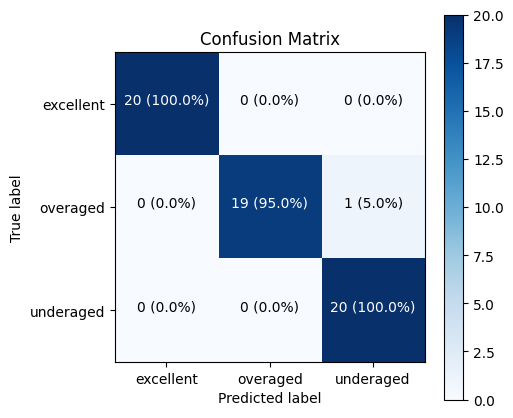

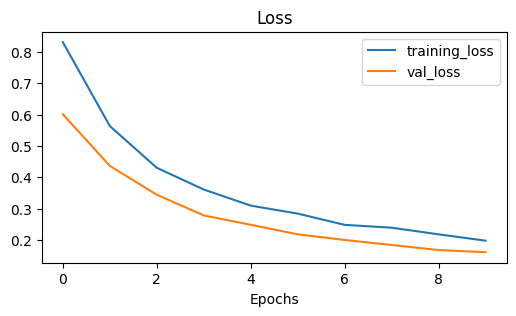

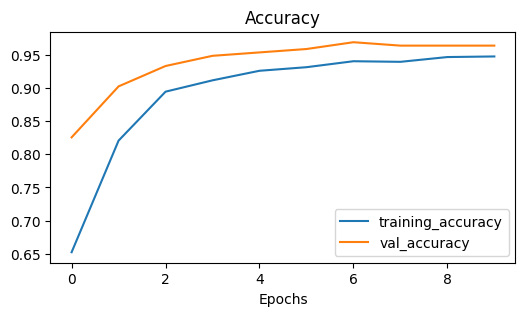

In [7]:
#Generate needed details
generate_details(model_1,test_data,[history1])

In [ ]:
model_1.export(model_1.name)

# Model 1 EfficientNetB0 with fine-tuning

In [9]:
checkpoint_path

'checkpoints/Model_1_EfficientNetB0.weights.h5'

In [10]:
model_1.load_weights(checkpoint_path)
model_1.layers[1].trainable = False

for layer in model_1.layers[1].layers[-10:]:
    if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    
model_1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #set lower training rate
              metrics=["accuracy"],
              jit_compile = False)

initial_epochs = 10
fine_tune_epochs = initial_epochs + 10
model_1.name="Model_1_EfficientNetB0_with_fine-tuning"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_1.name)

history1_tuned = model_1.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=val_data,
                             initial_epoch=history1.epoch[-1], 
                             callbacks=[checkpoint_callback]
                            )

Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9254 - loss: 0.2396
Epoch 10: val_loss improved from inf to 0.12523, saving model to checkpoints/Model_1_EfficientNetB0_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 255ms/step - accuracy: 0.9254 - loss: 0.2389 - val_accuracy: 0.9692 - val_loss: 0.1252
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9604 - loss: 0.1260
Epoch 11: val_loss improved from 0.12523 to 0.09480, saving model to checkpoints/Model_1_EfficientNetB0_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 212ms/step - accuracy: 0.9606 - loss: 0.1257 - val_accuracy: 0.9744 - val_loss: 0.0948
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9707 - loss: 0.0982
Epoch 12: val_loss improved from 0.09480 to 0.07796, saving model to checkpoints/Model_1_EfficientNetB0_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 216ms/step - accuracy: 0.9708 - loss: 0.0979 - val_accuracy: 0.9744 - val_loss: 0.

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9889 - loss: 0.0254
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
done.
Close? True | Difference: -4.371007278347605e-08


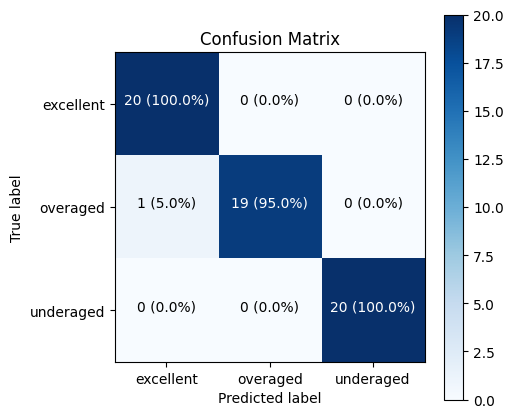

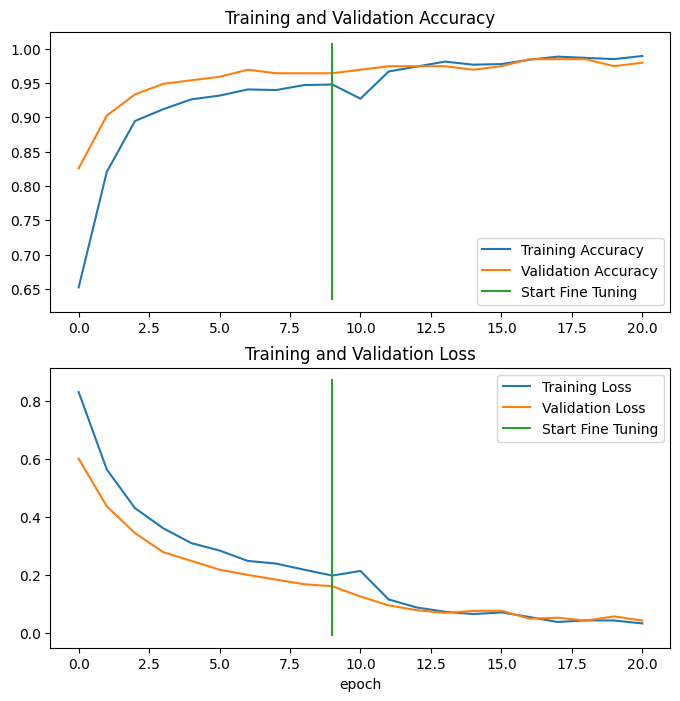

In [11]:
#Generate needed details
generate_details(model_1,test_data,[history1,history1_tuned,10],True)

In [ ]:
model_1.export(model_1.name)

# Model 2 EfficientNetB0 with augmentation

In [13]:
data_augmentation = keras.Sequential([
  layers.RandomZoom(0.1,0.3),
  layers.RandomFlip("horizontal"),
], name ="data_augmentation")

input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(3, activation="softmax", name="output_layer")(x)
model_2 = keras.Model(inputs, outputs)

model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)

model_2.name="Model_2_EfficientNetB0_with_augmentation"

(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_2.name)

history2 = model_2.fit(train_data,
                       epochs=10,
                       validation_data=val_data,
                       callbacks=[checkpoint_callback]
                      )

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.5268 - loss: 1.0175
Epoch 1: val_loss improved from inf to 0.70010, saving model to checkpoints/Model_2_EfficientNetB0_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 266ms/step - accuracy: 0.5296 - loss: 1.0144 - val_accuracy: 0.7744 - val_loss: 0.7001
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7752 - loss: 0.6898
Epoch 2: val_loss improved from 0.70010 to 0.52643, saving model to checkpoints/Model_2_EfficientNetB0_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step - accuracy: 0.7756 - loss: 0.6888 - val_accuracy: 0.8513 - val_loss: 0.5264
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8292 - loss: 0.5528
Epoch 3: val_loss improved from 0.52643 to 0.43227, saving model to checkpoints/Model_2_EfficientNetB0_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 222ms/step - accuracy: 0.8296 - loss: 0.5520 - val_accuracy: 0.8821 - val_loss: 0.432

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9347 - loss: 0.1951
done.
Predicting...


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f8520611dc0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
done.
Close? True | Difference: -5.563100180516756e-08


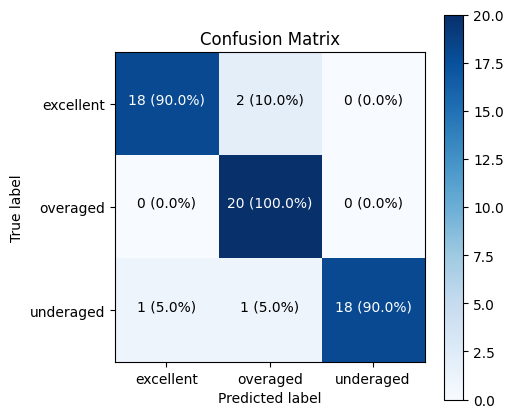

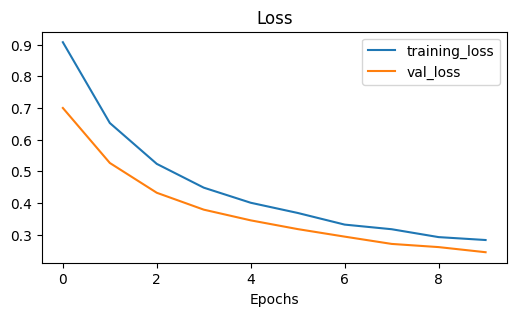

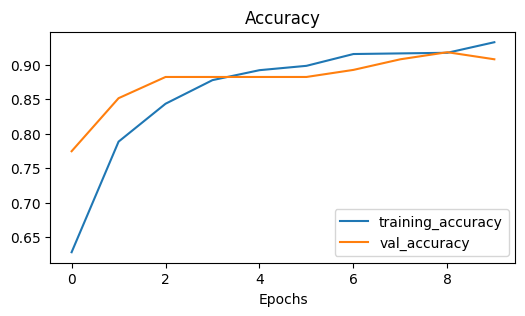

In [14]:
#Generate needed details
generate_details(model_2,test_data,[history2])

In [ ]:
model_2.export(model_2.name)

# Model 2 EfficientNetB0 with augmentation and fine-tuning

In [16]:
model_2.load_weights(checkpoint_path)
model_2.layers[2].trainable = False

for layer in model_2.layers[2].layers[-10:]:
    if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

model_2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #set lower training rate
              metrics=["accuracy"],
              jit_compile = False)

model_2.name = "Model_2_EfficientNetB0_with_augmentation_and_fine-tuning"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_2.name)

initial_epochs = 10
fine_tune_epochs = initial_epochs + 10
history2_tuned = model_2.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=val_data,
                             initial_epoch=history2.epoch[-1],
                             callbacks=[checkpoint_callback]
                            )

Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8874 - loss: 0.3369
Epoch 10: val_loss improved from inf to 0.18264, saving model to checkpoints/Model_2_EfficientNetB0_with_augmentation_and_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 266ms/step - accuracy: 0.8881 - loss: 0.3350 - val_accuracy: 0.9385 - val_loss: 0.1826
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9308 - loss: 0.1857
Epoch 11: val_loss improved from 0.18264 to 0.12898, saving model to checkpoints/Model_2_EfficientNetB0_with_augmentation_and_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - accuracy: 0.9311 - loss: 0.1850 - val_accuracy: 0.9436 - val_loss: 0.1290
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9475 - loss: 0.1349
Epoch 12: val_loss improved from 0.12898 to 0.12554, saving model to checkpoints/Model_2_EfficientNetB0_with_augmentation_and_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - accuracy: 0.9476 -

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9569 - loss: 0.0616
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
done.
Close? True | Difference: -8.74201456779744e-08


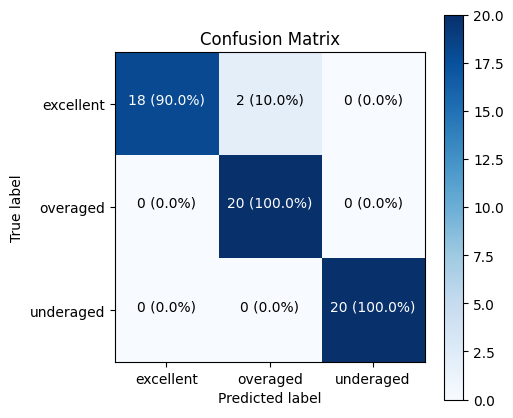

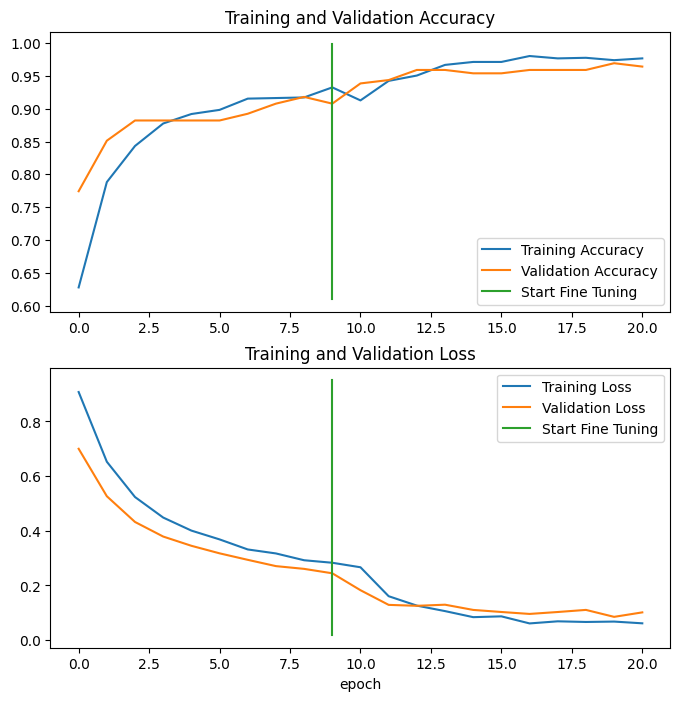

In [17]:
#Generate needed details
generate_details(model_2,test_data,[history2,history2_tuned,10],True)

In [ ]:
model_2.export(model_2.name)

# Model 3 ResNet50v2

In [19]:
base_model = tf.keras.applications.ResNet50V2(include_top=False)
base_model.trainable = False
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = layers.Rescaling(1./255,name="rescaler")(inputs)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(3, activation="softmax", name="output_layer")(x)
model_3 = tf.keras.Model(inputs, outputs)

model_3.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)

model_3.name = "Model_3_ResNet50v2"

(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_3.name)

history3 = model_3.fit(train_data,
                       epochs=10,
                       validation_data=val_data,
                       callbacks=[checkpoint_callback]
                      )

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.3878 - loss: 1.6543
Epoch 1: val_loss improved from inf to 0.69138, saving model to checkpoints/Model_3_ResNet50v2.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step - accuracy: 0.3898 - loss: 1.6447 - val_accuracy: 0.7436 - val_loss: 0.6914
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7048 - loss: 0.7368
Epoch 2: val_loss improved from 0.69138 to 0.48890, saving model to checkpoints/Model_3_ResNet50v2.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.7054 - loss: 0.7355 - val_accuracy: 0.8308 - val_loss: 0.4889
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.7775 - loss: 0.5260
Epoch 3: val_loss improved from 0.48890 to 0.36520, saving model to checkpoints/Model_3_ResNet50v2.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.7776 - loss: 0.5258 - val_accuracy: 0.8821 - val_loss: 0.3652
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step - accuracy: 0.9451 - loss: 0.2067
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
done.
Close? True | Difference: -5.563100180516756e-08


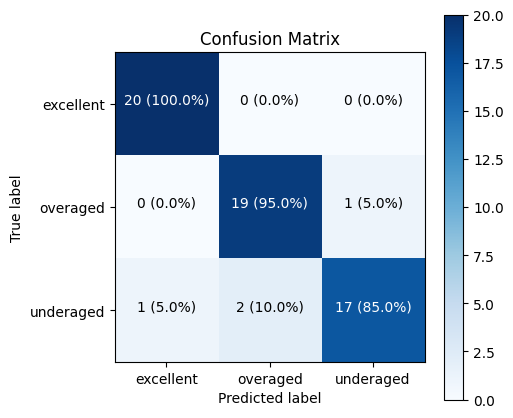

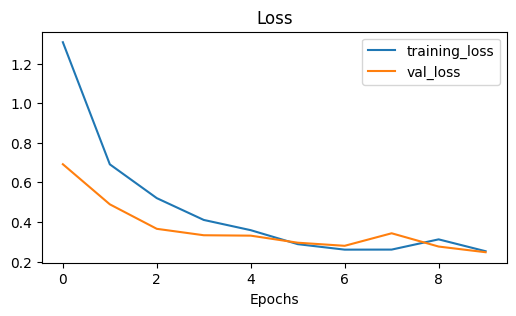

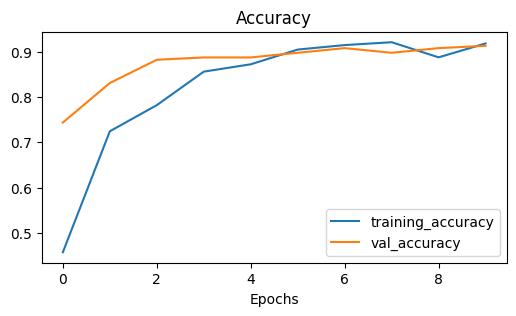

In [20]:
#Generate needed details
generate_details(model_3,test_data,[history3])

In [ ]:
model_3.export(model_3.name)

# Model 3 ResNet50v2 with fine-tuning

In [22]:
model_3.load_weights(checkpoint_path)
model_3.layers[2].trainable = False

for layer in model_3.layers[2].layers[-10:]:
    if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

model_3.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #set lower training rate 0.001 is default
              metrics=["accuracy"],
              jit_compile = False)

model_3.name = "Model_3_ResNet50v2_with_fine-tuning"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_3.name)

initial_epochs = 10
fine_tune_epochs = initial_epochs + 10
history3_tuned = model_3.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=val_data,
                             initial_epoch=history3.epoch[-1],
                             callbacks=[checkpoint_callback]
                            )

Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8813 - loss: 0.2845
Epoch 10: val_loss improved from inf to 0.17132, saving model to checkpoints/Model_3_ResNet50v2_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - accuracy: 0.8821 - loss: 0.2828 - val_accuracy: 0.9333 - val_loss: 0.1713
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9642 - loss: 0.1012
Epoch 11: val_loss improved from 0.17132 to 0.09962, saving model to checkpoints/Model_3_ResNet50v2_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9644 - loss: 0.1007 - val_accuracy: 0.9692 - val_loss: 0.0996
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9836 - loss: 0.0430
Epoch 12: val_loss improved from 0.09962 to 0.06380, saving model to checkpoints/Model_3_ResNet50v2_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9838 - loss: 0.0427 - val_accuracy: 0.9744 - val_loss: 0.0638
Epoch 1

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0094
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 967ms/step
done.
Close? True | Difference: -5.960464477539063e-08


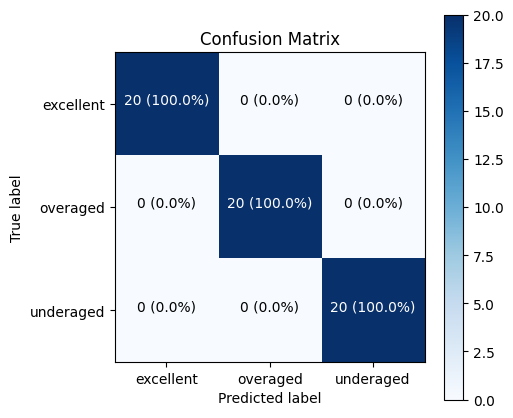

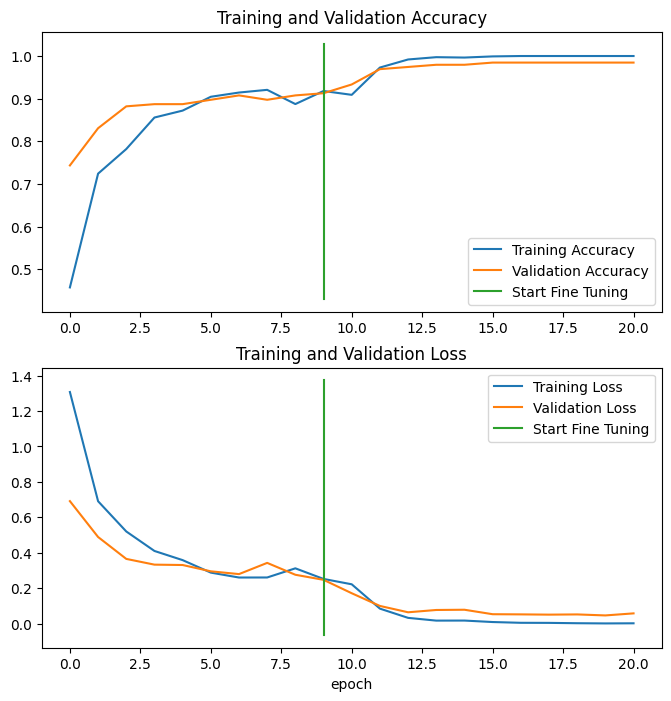

In [23]:
#Generate needed details
generate_details(model_3,test_data,[history3,history3_tuned,10],True)

In [ ]:
model_3.export(model_3.name)

# Model 4 ResNet50v2 with augmentation

In [25]:
data_augmentation = keras.Sequential([
  layers.RandomZoom(0.1,0.3),
  layers.RandomFlip("horizontal"),
], name ="data_augmentation")


input_shape = (224, 224, 3)
base_model = tf.keras.applications.ResNet50V2(include_top=False)
base_model.trainable = False
inputs = layers.Input(shape=input_shape, name="input_layer")

x = data_augmentation(inputs)
x = layers.Rescaling(1./255, name="rescaler")(x)
x = base_model(x)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(3, activation="softmax", name="output_layer")(x)
model_4 = keras.Model(inputs, outputs)

model_4.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)

model_4.name = "Model_4_ResNet50v2_with_augmentation"

(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_4.name)

history4 = model_4.fit(train_data,
                       epochs=10,
                       validation_data=val_data,
                       callbacks=[checkpoint_callback]
                      )

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.4348 - loss: 1.3794
Epoch 1: val_loss improved from inf to 0.71986, saving model to checkpoints/Model_4_ResNet50v2_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - accuracy: 0.4366 - loss: 1.3731 - val_accuracy: 0.7333 - val_loss: 0.7199
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.6426 - loss: 0.8140
Epoch 2: val_loss improved from 0.71986 to 0.50649, saving model to checkpoints/Model_4_ResNet50v2_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.6438 - loss: 0.8121 - val_accuracy: 0.8051 - val_loss: 0.5065
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7314 - loss: 0.6246
Epoch 3: val_loss improved from 0.50649 to 0.41761, saving model to checkpoints/Model_4_ResNet50v2_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.7321 - loss: 0.6242 - val_accuracy: 0.8462 - val_loss: 0.4176
Epoch 4/10

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9340 - loss: 0.2336
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 982ms/step
done.
Close? True | Difference: -3.973642981325298e-08


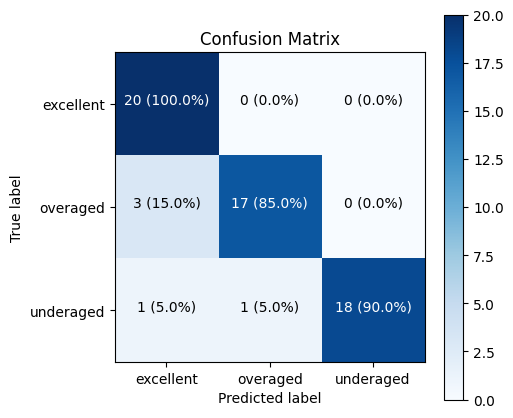

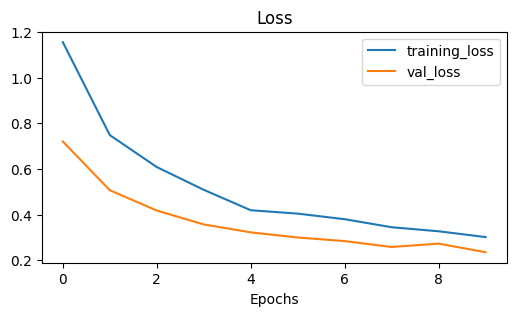

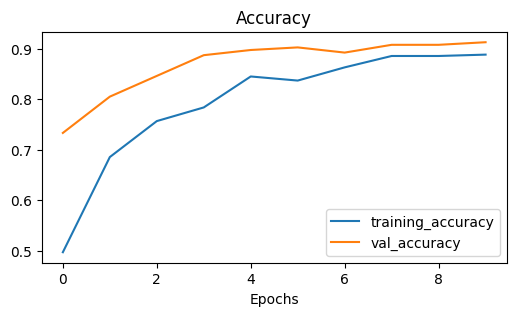

In [26]:
#Generate needed details
generate_details(model_4,test_data,[history4])

In [ ]:
model_4.export(model_4.name)

# Model 4 ResNet50v2 with augmentation with fine-tuning

In [28]:
model_4.load_weights(checkpoint_path)
model_4.layers[3].trainable = False

for layer in model_4.layers[3].layers[-10:]:
    if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

model_4.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005), #set lower training rate
              metrics=["accuracy"],
              jit_compile = False)

model_4.name = "Model_4_ResNet50v2_with_augmentation_with_fine-tuning"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_4.name)

initial_epochs = 10
fine_tune_epochs = initial_epochs + 10
history4_tuned = model_4.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=val_data,
                             initial_epoch=history4.epoch[-1],
                             callbacks=[checkpoint_callback]
                            )

Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8873 - loss: 0.2795
Epoch 10: val_loss improved from inf to 0.21272, saving model to checkpoints/Model_4_ResNet50v2_with_augmentation_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 192ms/step - accuracy: 0.8869 - loss: 0.2800 - val_accuracy: 0.9128 - val_loss: 0.2127
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9160 - loss: 0.2287
Epoch 11: val_loss improved from 0.21272 to 0.16847, saving model to checkpoints/Model_4_ResNet50v2_with_augmentation_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.9161 - loss: 0.2283 - val_accuracy: 0.9333 - val_loss: 0.1685
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9559 - loss: 0.1412
Epoch 12: val_loss did not improve from 0.16847
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.9557 - loss: 0.1416 - val_accuracy: 0.9436 - val_loss: 0.1760
Epoch 13/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/ste

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9451 - loss: 0.1159
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 942ms/step
done.
Close? True | Difference: -5.563100180516756e-08


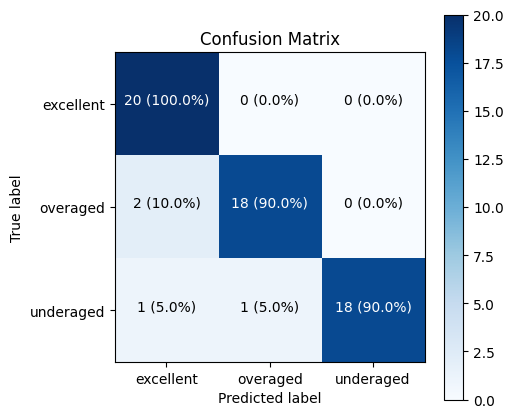

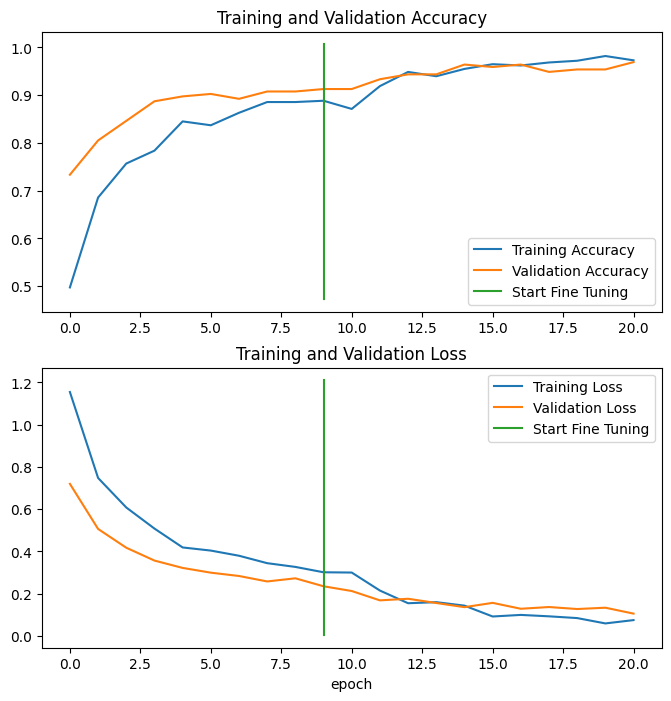

In [29]:
#Generate needed details
generate_details(model_4,test_data,[history4,history4_tuned,10],True)

In [ ]:
model_4.export(model_4.name)

# Model 5 VGG16

In [31]:
base_model = tf.keras.applications.VGG16(include_top=False)
base_model.trainable = False
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")

x = layers.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(x)
# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(3, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_5 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_5.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)

model_5.name = "Model_5_VGG16"

(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_5.name)

history5 = model_5.fit(train_data,
                       epochs=10,
                       validation_data=val_data,
                       callbacks=[checkpoint_callback]
                      )

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.3404 - loss: 1.1400
Epoch 1: val_loss improved from inf to 1.10194, saving model to checkpoints/Model_5_VGG16.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.3409 - loss: 1.1391 - val_accuracy: 0.3333 - val_loss: 1.1019
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.3281 - loss: 1.0978
Epoch 2: val_loss improved from 1.10194 to 1.08133, saving model to checkpoints/Model_5_VGG16.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.3285 - loss: 1.0978 - val_accuracy: 0.3590 - val_loss: 1.0813
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.3602 - loss: 1.0844
Epoch 3: val_loss improved from 1.08133 to 1.07141, saving model to checkpoints/Model_5_VGG16.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.3612 - loss: 1.0842 - val_accuracy: 0.3692 - val_loss: 1.0714
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.4257 - loss: 1

In [32]:
model_5.summary()

Model: "Model_5_VGG16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,719,307 (56.15 MB)

 Trainable params: 1,539 (6.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 3,080 (12.04 KB)

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step - accuracy: 0.5333 - loss: 0.9986
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
done.
Close? True | Difference: -4.768371586472142e-08


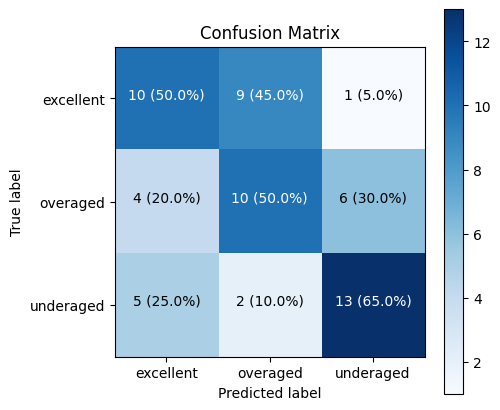

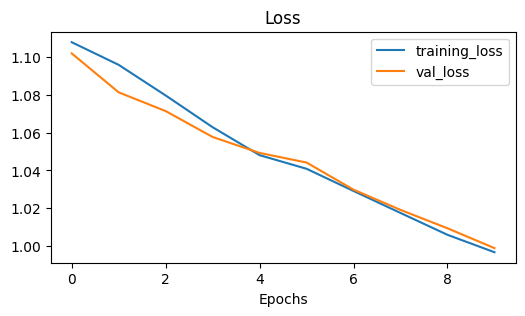

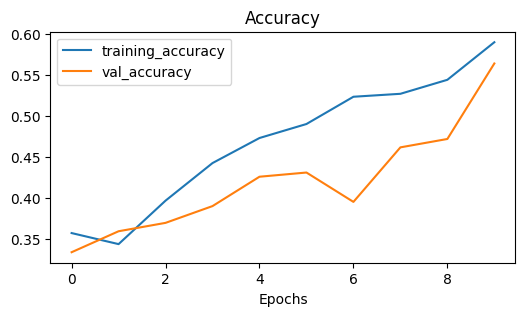

In [33]:
#Generate needed details
generate_details(model_5,test_data,[history5])

In [34]:
model_5.export(model_5.name)

INFO:tensorflow:Assets written to: Model_5_VGG16/assets


INFO:tensorflow:Assets written to: Model_5_VGG16/assets


Saved artifact at 'Model_5_VGG16'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140209708204624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140209708204800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140207795951392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140207795952624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140208151303440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140208151303792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140207793150608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140207793328368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140207786072016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140207786071664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140207786072544: T

# Model 5 VGG16 with fine-tuning

In [35]:
model_5.load_weights(checkpoint_path)
model_5.layers[2].trainable = False

for layer in model_5.layers[2].layers[-10:]:
    if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

model_5.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00007), #set lower training rate 0.001 is default
              metrics=["accuracy"],
              jit_compile = False)

model_5.name = "Model_5_VGG16_with_fine-tuning"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_5.name)

initial_epochs = 10
fine_tune_epochs = initial_epochs + 10
history5_tuned = model_5.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=val_data,
                             initial_epoch=history5.epoch[-1],
                             callbacks=[checkpoint_callback]
                            )

Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.5213 - loss: 1.0416
Epoch 10: val_loss improved from inf to 0.42119, saving model to checkpoints/Model_5_VGG16_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - accuracy: 0.5238 - loss: 1.0366 - val_accuracy: 0.8205 - val_loss: 0.4212
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.8393 - loss: 0.3830
Epoch 11: val_loss improved from 0.42119 to 0.15463, saving model to checkpoints/Model_5_VGG16_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.8406 - loss: 0.3805 - val_accuracy: 0.9282 - val_loss: 0.1546
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9455 - loss: 0.1428
Epoch 12: val_loss improved from 0.15463 to 0.09158, saving model to checkpoints/Model_5_VGG16_with_fine-tuning.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 226ms/step - accuracy: 0.9459 - loss: 0.1420 - val_accuracy: 0.9590 - val_loss: 0.0916
Epoch 13/20
35/35 ━━━━

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 5.1284e-04
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
done.
Close? True | Difference: -5.960464477539063e-08


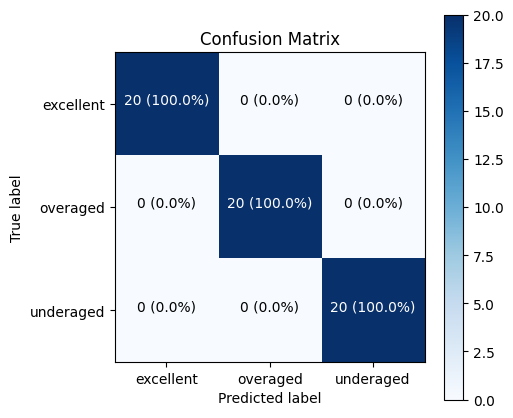

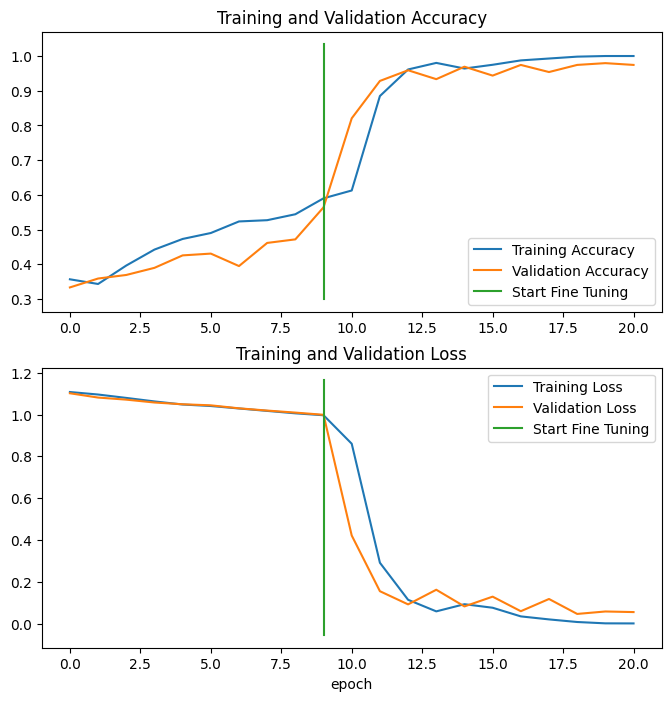

In [36]:
#Generate needed details
generate_details(model_5,test_data,[history5,history5_tuned,10],True)

In [ ]:
model_5.export(model_5.name)

# Model 6 VGG16 with augmentation

In [38]:
data_augmentation = keras.Sequential([
  layers.RandomZoom(0.1,0.3),
  layers.RandomFlip("horizontal"),
], name ="data_augmentation")

input_shape = (224, 224, 3)
base_model = tf.keras.applications.VGG16(include_top=False)
base_model.trainable = False
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = layers.Rescaling(1./255, name="rescaler")(x)
x = base_model(x)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(3, activation="softmax", name="output_layer")(x)
model_6 = keras.Model(inputs, outputs)

model_6.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              jit_compile = False)

model_6.name = "Model_6_VGG16_with_augmentation"

(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_6.name)

history6 = model_6.fit(train_data,
                       epochs=10,
                       validation_data=val_data,
                       callbacks=[checkpoint_callback]
                      )

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.3616 - loss: 1.1164
Epoch 1: val_loss improved from inf to 1.10522, saving model to checkpoints/Model_6_VGG16_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - accuracy: 0.3612 - loss: 1.1162 - val_accuracy: 0.3231 - val_loss: 1.1052
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.3411 - loss: 1.0924
Epoch 2: val_loss improved from 1.10522 to 1.09174, saving model to checkpoints/Model_6_VGG16_with_augmentation.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.3419 - loss: 1.0923 - val_accuracy: 0.3487 - val_loss: 1.0917
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.4091 - loss: 1.0798
Epoch 3: val_loss did not improve from 1.09174
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 0.4093 - loss: 1.0797 - val_accuracy: 0.3795 - val_loss: 1.1007
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.3757 - loss: 1.0825
Epoch 4: val_los

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.4049 - loss: 1.0282
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step  
done.
Close? True | Difference: -2.781550090258378e-08


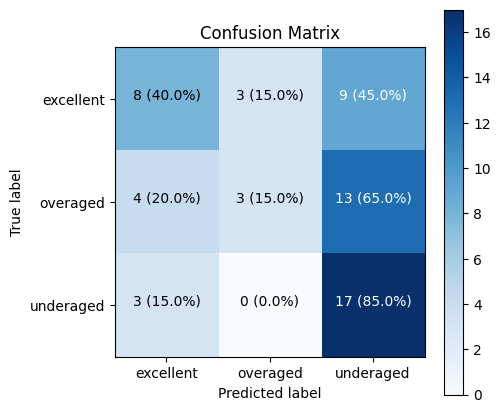

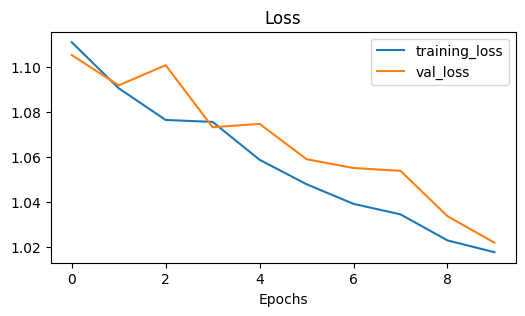

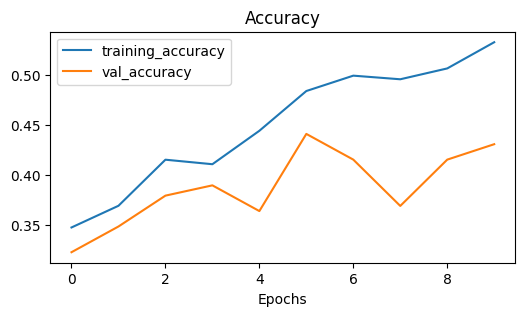

In [39]:
#Generate needed details
generate_details(model_6,test_data,[history6])

In [ ]:
model_6.export(model_6.name)

# Model 6 VGG16 with augmentation and fine-tuning

In [41]:
model_6.load_weights(checkpoint_path)
model_6.layers[3].trainable = False

for layer in model_6.layers[3].layers[-10:]:
    if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

model_6.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00007), #set lower training rate
              metrics=["accuracy"])

model_6.name = "Model_6_VGG16_with_augmentation_and_fine-tuningn"
(checkpoint_callback,checkpoint_path)=setup_checkpoint(model_6.name)

initial_epochs = 10
fine_tune_epochs = initial_epochs + 10
history6_tuned = model_6.fit(train_data,
                             epochs=fine_tune_epochs,
                             validation_data=val_data,
                             initial_epoch=history6.epoch[-1],
                             callbacks=[checkpoint_callback]
                            )

Epoch 10/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.3794 - loss: 1.1372
Epoch 10: val_loss improved from inf to 1.07701, saving model to checkpoints/Model_6_VGG16_with_augmentation_and_fine-tuningn.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 263ms/step - accuracy: 0.3792 - loss: 1.1365 - val_accuracy: 0.4308 - val_loss: 1.0770
Epoch 11/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.4261 - loss: 1.0531
Epoch 11: val_loss improved from 1.07701 to 0.92672, saving model to checkpoints/Model_6_VGG16_with_augmentation_and_fine-tuningn.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 262ms/step - accuracy: 0.4268 - loss: 1.0525 - val_accuracy: 0.6308 - val_loss: 0.9267
Epoch 12/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.6626 - loss: 0.7615
Epoch 12: val_loss improved from 0.92672 to 0.28273, saving model to checkpoints/Model_6_VGG16_with_augmentation_and_fine-tuningn.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 259ms/step - accuracy: 0.6645 - loss: 0.7573 - val_accu

## results

Evaluating...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9667 - loss: 0.0547
done.
Predicting...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
done.
Close? True | Difference: -7.152557368605983e-08


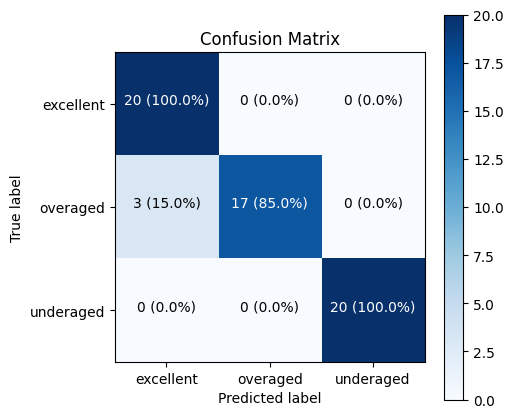

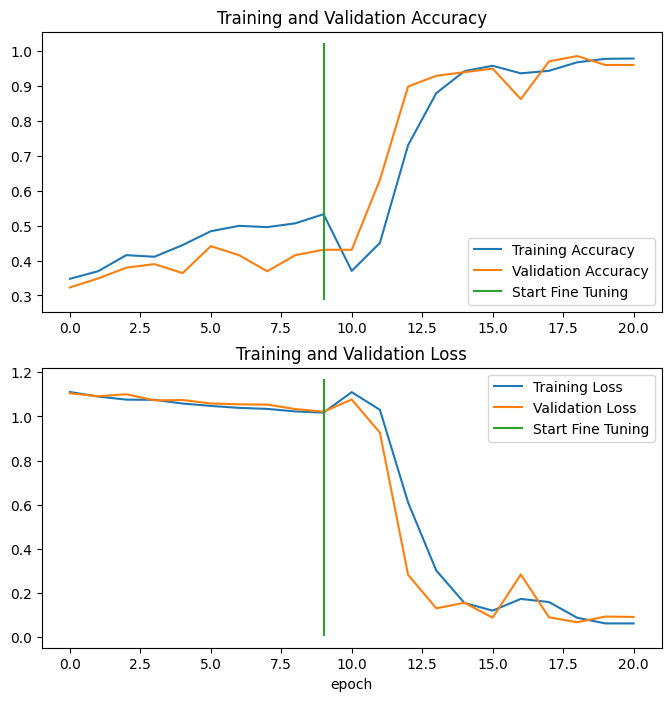

In [42]:
#Generate needed details
generate_details(model_6,test_data,[history6,history6_tuned,10],True)

In [ ]:
model_6.export(model_6.name)

# RESULT SUMMARY

In [44]:
show_results(res)

,Model,Loss,Accuracy
0,Model_1_EfficientNetB0,15.7591,98.3333
1,Model_1_EfficientNetB0_with_fine-tuning,3.3254,98.3333
2,Model_2_EfficientNetB0_with_augmentation,20.8776,93.3333
3,Model_2_EfficientNetB0_with_augmentation_and_f...,4.9156,96.6667
4,Model_3_ResNet50v2,23.5187,93.3333
5,Model_3_ResNet50v2_with_fine-tuning,1.0170,100.0000
6,Model_4_ResNet50v2_with_augmentation,27.7278,91.6667
7,Model_4_ResNet50v2_with_augmentation_with_fine...,13.2407,93.3333
8,Model_5_VGG16,98.5075,55.0000
9,Model_5_VGG16_with_fine-tuning,0.0477,100.0000


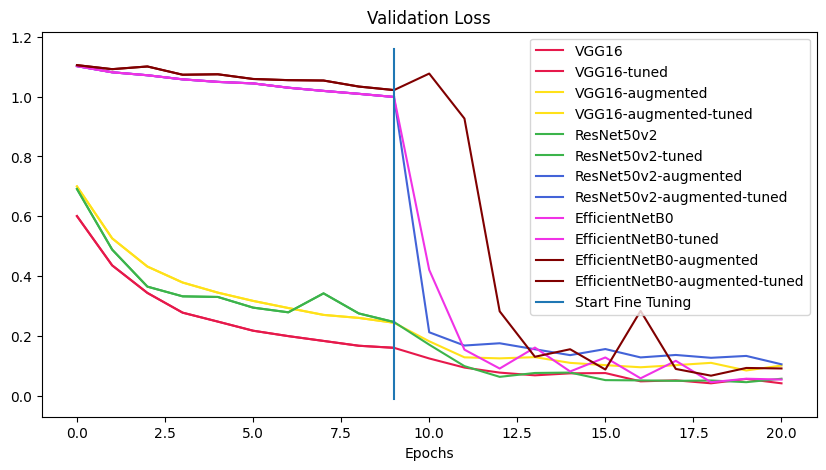

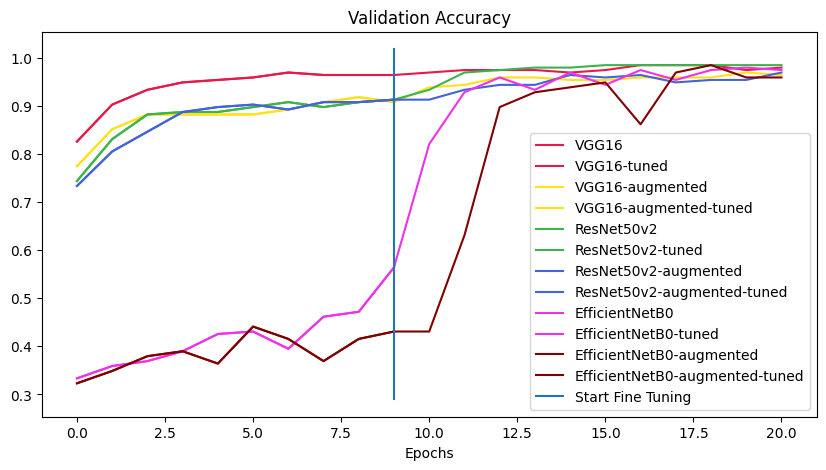

In [45]:
plot_all_curves(
    history=[history1,
             history2,
             history3,
             history4,
             history5,
             history6,
            ],
    new_history=[
        history1_tuned,
        history2_tuned,
        history3_tuned,
        history4_tuned,
        history5_tuned,
        history6_tuned
        ],
    model_name="all")